In [ ]:
# pandasのインポート
import pandas as pd

# tsvファイルの読み込み
df1 = pd.read_csv("Boston2_kouka2_1.tsv", sep="\t")
df2 = pd.read_csv("Boston2_kouka2_2.tsv", sep="\t")

In [ ]:
# df1の表示
df1.head()

犯罪    広さ     産業  川辺  窒素酸化物    部屋数    古さ    主要施設  高速道路   税金  生徒と先生  \
0      high   0.0  18.10  no  0.718  3.561  87.9  1.6132  24.0  666   20.2   
1       low   0.0   8.14  no  0.538  5.950  82.0  3.9900   4.0  307   21.0   
2  very_low  82.5   2.03  no  0.415  6.162  38.4  6.2700   2.0  348   14.7   
3       low   0.0  21.89  no  0.624  6.151  97.9  1.6687   4.0  437   21.2   
4      high   0.0  18.10  no  0.614  6.980  67.6  2.5329  24.0  666   20.2   

       黒人    低所得    価格  
0  354.70   7.12  27.5  
1  232.60  27.71  13.2  
2  393.77   7.43  24.1  
3  396.90  18.46  17.8  
4  374.68  11.66  29.8

In [ ]:
# df2の表示
df2.head()

犯罪    広さ     産業  川辺  窒素酸化物    部屋数     古さ    主要施設  高速道路   税金  生徒と先生  \
0       low   0.0   8.14  no  0.538  5.965   89.2  4.0123     4  307   21.0   
1  very_low   0.0   4.05  no  0.510  6.416   84.1  2.6463     5  296   16.6   
2  very_low  40.0   6.41  no  0.447  6.854   42.8  4.2673     4  254   17.6   
3       low   0.0   9.90  no  0.544  6.382   67.2  3.5325     4  304   18.4   
4      high   0.0  18.10  no  0.718  6.411  100.0  1.8589    24  666   20.2   

       黒人    低所得    価格  
0  392.53  13.83  19.6  
1  395.50   9.04  23.6  
2  396.90   2.98  32.0  
3  395.21  10.36  23.1  
4  318.75  15.02  16.7

In [ ]:
# 縦方向の連結
df = pd.concat([df1, df2], axis=0)

# 行数と列数の表示
df.shape

(100, 14)

In [ ]:
# 犯罪列と川辺列をダミー変数化したものをそれぞれ変数に代入
crime = pd.get_dummies(df["犯罪"], drop_first=True)
river = pd.get_dummies(df["川辺"], drop_first=True)

# 元のデータフレームから二列分を削除
df_deleted = pd.concat([df.loc[:, "広さ":"産業"], df.loc[:, "窒素酸化物":]], axis=1)

# ダミー変数化したものを連結
df_dummied = pd.concat([df_deleted, crime, river], axis=1)

In [ ]:
# 描画に必要なインストールとインポート
!pip install japanize-matplotlib
import japanize_matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

     |████████████████████████████████| 4.1 MB 8.8 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=860acaf4a72ac858e42a1b4b039c116ed52baeceddb277a4ae8af96521f0a697
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


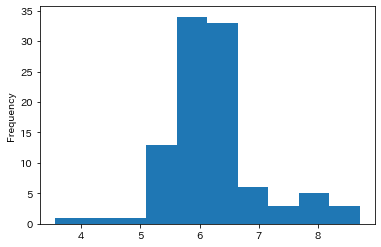

In [ ]:
# 部屋数のヒストグラムの描画
df_dummied["部屋数"].plot(kind="hist")

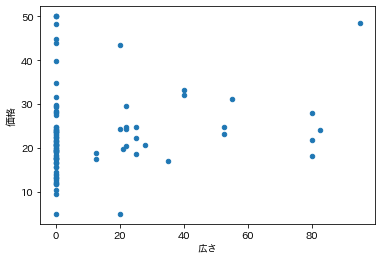

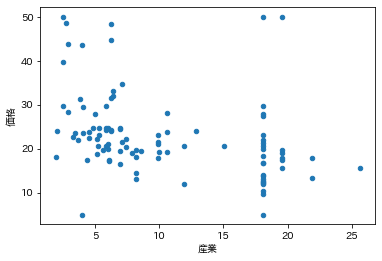

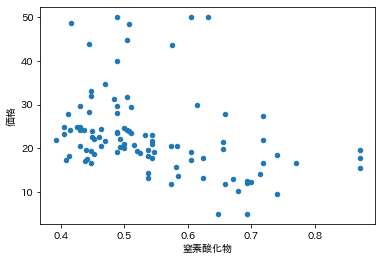

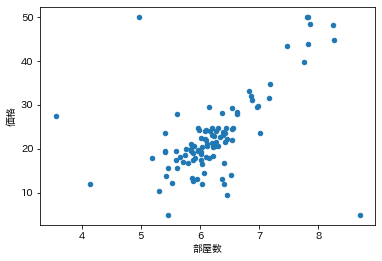

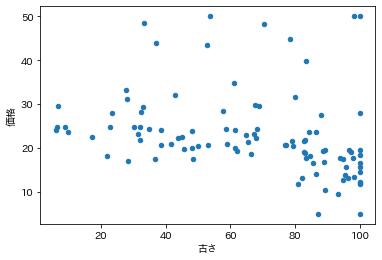

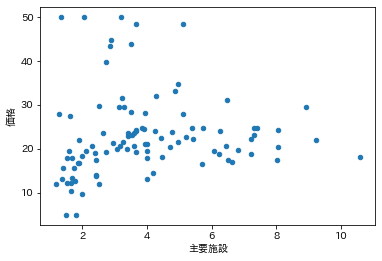

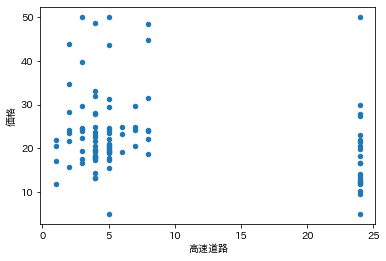

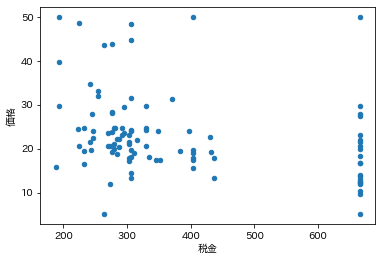

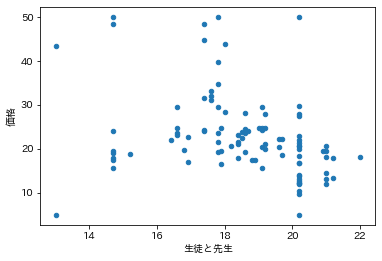

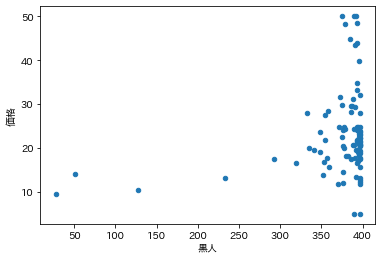

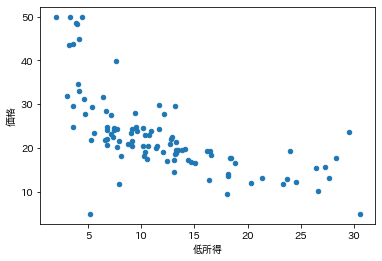

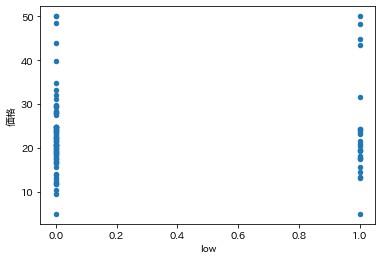

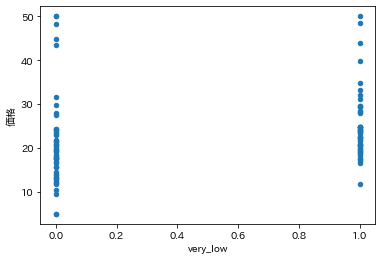

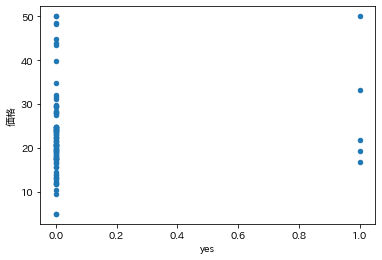

In [ ]:
# 価格列と、価格列以外の散布図描画
for col in df_dummied:
  if col != "価格":
    df_dummied.plot(kind="scatter", x=col, y="価格")

In [ ]:
# 目視による外れ値の削除
df_dropped = df_dummied.drop(df_dummied.loc[(df_dummied["部屋数"]<6) & (df_dummied["価格"]>40)].index, axis=0)
df_dropped = df_dropped.drop(df_dropped.loc[(df_dropped["部屋数"]>8) & (df_dropped["価格"]<10)].index, axis=0)
df_dropped = df_dropped.drop(df_dropped.loc[(df_dropped["高速道路"]>20) & (df_dropped["価格"]>40)].index, axis=0)
df_dropped = df_dropped.drop(df_dropped.loc[(df_dropped["税金"]>600) & (df_dropped["価格"]>40)].index, axis=0)
df_dropped = df_dropped.drop(df_dropped.loc[(df_dropped["生徒と先生"]<14) & (df_dropped["価格"]<10)].index, axis=0)
df_dropped = df_dropped.drop(df_dropped.loc[(df_dropped["低所得"]<10) & (df_dropped["価格"]<10)].index, axis=0)
df_dropped = df_dropped.drop(df_dropped.loc[(df_dropped["古さ"]>90) & (df_dropped["価格"]>45)].index, axis=0)

In [ ]:
# インデックスの割り振りなおし
df_dropped.index = list(range(df_dropped.shape[0]))

In [ ]:
# マハラノビス距離による外れ値の削除
# インポート
from sklearn.covariance import MinCovDet

# 外れ値を返す関数定義
"""引数：df->データフレーム、"""
def calcDistance(df, name):
  """データフレームから指定したカラムの外れ値をマハラノビス距離で探し、インデックスを返す関数

    引数:
    df -- DataFrame
    name -- リスト(カラム名)

    Return:
    リスト(外れ値の一覧)
    """
  new = df[name]
  new = new.dropna()
  mcd = MinCovDet(random_state=0, support_fraction=0.7)
  mcd.fit(new)
  distance = pd.Series(mcd.mahalanobis(new))
  tmp = distance.describe()
  iqr = tmp["75%"]-tmp["25%"]
  upper = 1.5*(iqr)+tmp["75%"]
  lower = tmp["25%"]-1.5*(iqr)
  outliner = distance[(distance>upper) | (distance<lower)]
  print(outliner.index)
  return outliner.index

In [ ]:
# 外れ値を一覧で格納するリストの定義
lst = []

# 外れ値を探すカラムの定義(選定基準：目視では分かりにくい、多項式特徴量としたときに外れ値になりうる値がありそうなもの)
cols = [["生徒と先生"], ["産業"]]

# 列分繰り返して外れ値のインデックスを列挙
for col in cols:
  print(col)
  newlst = calcDistance(df_dropped, col)
  for ind in newlst:
    if ind not in lst:
      lst.append(ind)

# 表示が分かりやすいようにソート
lst.sort()
print("外れ値：", lst)

['生徒と先生']
Int64Index([2, 11, 18, 25, 37, 64, 69, 81, 85, 87], dtype='int64')
['産業']
Int64Index([43], dtype='int64')
外れ値： [2, 11, 18, 25, 37, 43, 64, 69, 81, 85, 87]


In [ ]:
# 外れ値の削除と、その前後での行数の変化
print("削除前：", df_dropped.shape)
for ind in lst:
  df_dropped.drop(ind, axis=0, inplace=True)
print("削除後", df_dropped.shape)

削除前： (94, 15)
削除後 (83, 15)


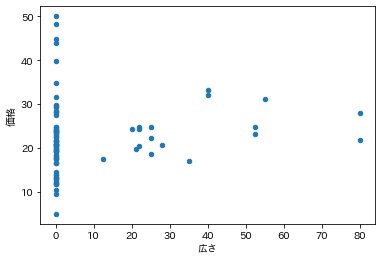

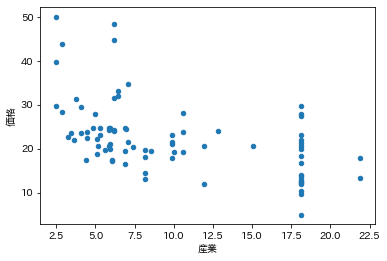

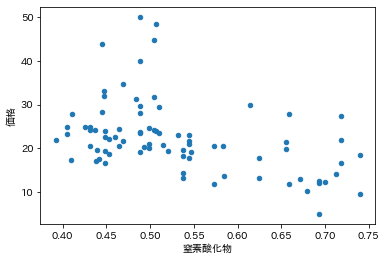

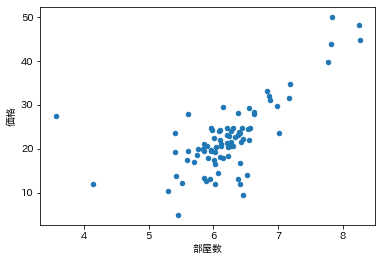

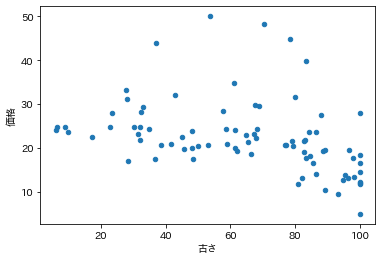

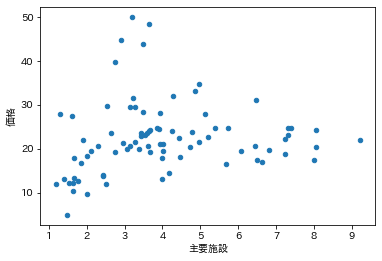

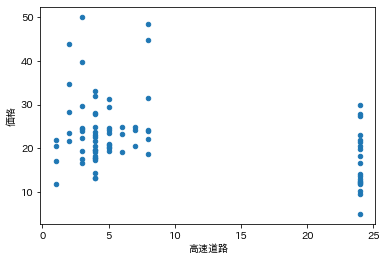

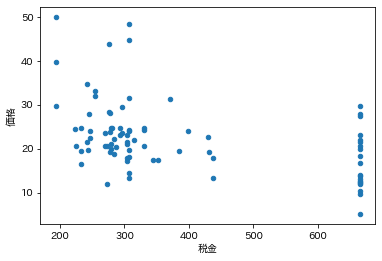

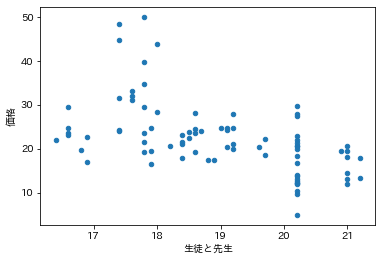

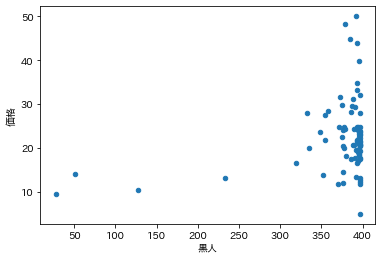

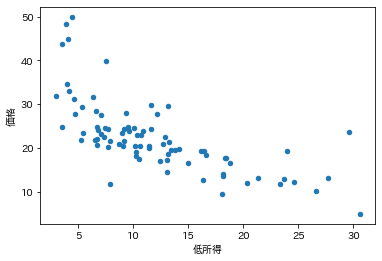

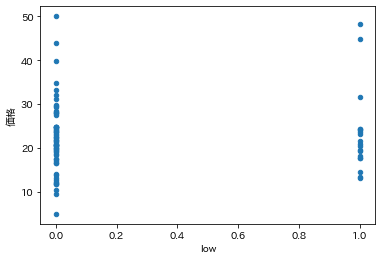

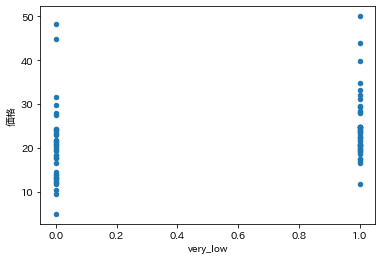

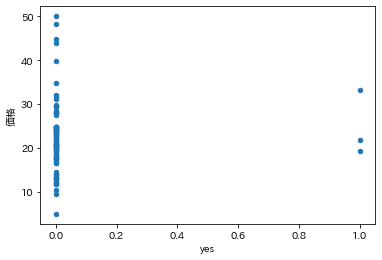

In [ ]:
# 削除後のデータにおける価格列と、価格列以外の散布図描画
for col in df_dropped:
  if col != "価格":
    df_dropped.plot(kind="scatter", x=col, y="価格")

In [ ]:
# 欠損値の有無の確認
df_dropped.isnull().any(axis=0)

広さ          False
産業          False
窒素酸化物        True
部屋数         False
古さ          False
主要施設        False
高速道路         True
税金          False
生徒と先生       False
黒人          False
低所得         False
価格          False
low         False
very_low    False
yes         False
dtype: bool

0.5300963414634148
0.504


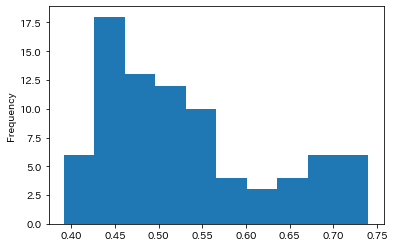

In [ ]:
# 削除に適した数値の判断
df_dropped["窒素酸化物"].plot(kind="hist", alpha=1)
print(df_dropped["窒素酸化物"].mean())
print(df_dropped["窒素酸化物"].median())

9.134146341463415
5.0


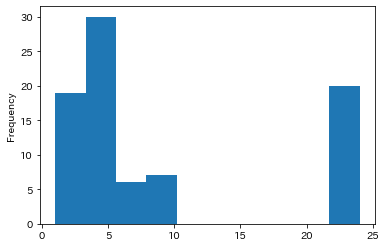

In [ ]:
df_dropped["高速道路"].plot(kind="hist", alpha=1)
print(df_dropped["高速道路"].mean())
print(df_dropped["高速道路"].median())

In [ ]:
# 欠損値の補完 -> 窒素酸化物は偏りがあり、高速道路は過剰な外れ値の削除を避けるために残した外れ値があるため中央値で補完
df_fillna = df_dropped.fillna(df_dropped.median())

# 欠損値の有無の確認
df_fillna.isnull().any(axis=0)

広さ          False
産業          False
窒素酸化物       False
部屋数         False
古さ          False
主要施設        False
高速道路        False
税金          False
生徒と先生       False
黒人          False
低所得         False
価格          False
low         False
very_low    False
yes         False
dtype: bool

In [ ]:
# 相関係数の絶対値を降順で表示
df_fillna.corr()["価格"].map(abs).sort_values(ascending=False).iloc[1:]

部屋数         0.693377
低所得         0.687277
生徒と先生       0.527665
産業          0.509527
税金          0.435157
窒素酸化物       0.429214
古さ          0.377262
高速道路        0.344553
very_low    0.282358
黒人          0.275852
主要施設        0.133156
広さ          0.125395
yes         0.053606
low         0.045910
Name: 価格, dtype: float64

In [ ]:
# 特徴量の選択
x = df_fillna[["部屋数", "低所得", "生徒と先生"]]
t = df_fillna["価格"]

# 多項式特徴量の追加
x["1/産業"] = 1/df_fillna["産業"]
x["1/低所得"] = 1/df_fillna["低所得"]
x["部屋数**2"] = df_fillna["部屋数"]**2
x["黒人**4"] = df_fillna["黒人"]**4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


部屋数    低所得  生徒と先生      1/産業     1/低所得     部屋数**2         黒人**4
0   3.561   7.12   20.2  0.055249  0.140449  12.680721  1.582868e+10
1   5.950  27.71   21.0  0.122850  0.036088  35.402500  2.927109e+09
3   6.151  18.46   21.2  0.045683  0.054171  37.834801  2.481558e+10
4   6.980  11.66   20.2  0.055249  0.085763  48.720400  1.970798e+10
5   6.086  10.88   17.4  0.161290  0.091912  37.039396  2.014712e+10
..    ...    ...    ...       ...       ...        ...           ...
89  6.219  16.59   20.2  0.055249  0.060277  38.675961  2.451435e+10
90  5.759  14.13   20.2  0.055249  0.070771  33.166081  1.250446e+10
91  6.380  23.69   20.2  0.055249  0.042212  40.704400  2.481558e+10
92  5.914  18.33   18.4  0.101010  0.054555  34.975396  2.330095e+10
93  5.453  30.59   20.2  0.055249  0.032690  29.735209  2.481558e+10

[83 rows x 7 columns]

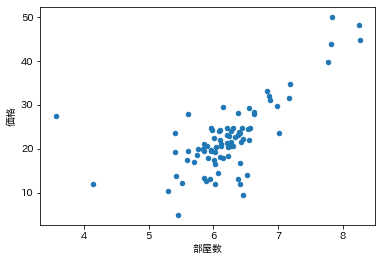

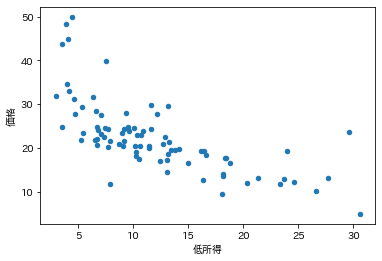

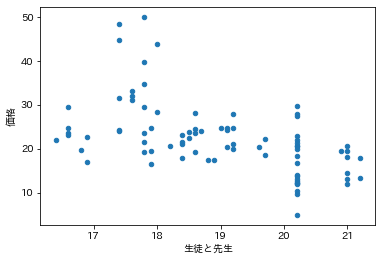

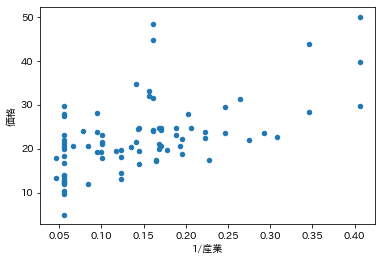

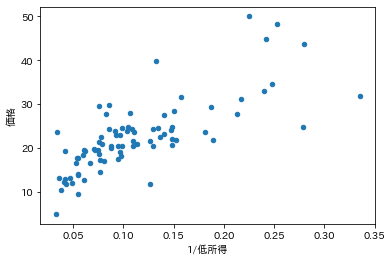

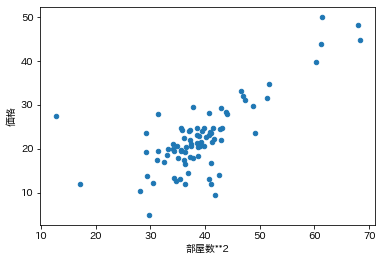

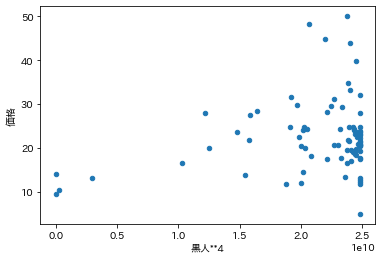

In [ ]:
# 多項式特徴量の正当性の確認
x["価格"] = df_fillna["価格"]
for col in x:
  if col != "価格":
    x.plot(kind="scatter", x=col, y="価格")
x.drop("価格", axis=1)

In [ ]:
# アダブーストとランダムフォレストの併用によって制度の向上を図る
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
base_model = RandomForestRegressor(n_estimators = 50, max_depth=5, random_state = 0)
model = AdaBoostRegressor(random_state = 0, n_estimators = 100, base_estimator = base_model)

In [ ]:
# K分割交差検証を行う
# インポート
from sklearn.model_selection import KFold, cross_validate

# kfの定義(分割数3)
kf = KFold(n_splits=3, shuffle=True, random_state=1)

# 決定係数を用いて検証
result = cross_validate(model, x, t, cv=kf, scoring="r2", return_train_score=True)
print(result)

# テストデータでの決定係数の平均を表示
print(sum(result["test_score"])/len(result["test_score"]))

{'fit_time': array([15.08628654,  7.85137486,  6.06483078]), 'score_time': array([0.98689914, 0.40041637, 0.4103415 ]), 'test_score': array([0.97174467, 0.96171052, 0.97085083]), 'train_score': array([0.99925382, 0.99916832, 0.99887229])}
0.9681020070654179


In [ ]:
# RSME計算用のインポート
from sklearn.metrics import mean_squared_error
import math

# 訓練データとテストデータへの分割
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, t, test_size=0.3, random_state=1)

# 学習
model.fit(x_train, y_train)


# MSEの計算
pred = model.predict(x_test)
mse = mean_squared_error(pred, y_test)

# RMSEの表示
print(math.sqrt(mse))

# 決定係数の表示
print(model.score(x_test, y_test))

# 様々なランダムシードで決定係数を算出
for i in range(10):
  x_train, x_test, y_train, y_test = train_test_split(x, t, test_size=0.3, random_state=i)
  model.fit(x_train, y_train)
  print(i, "での決定係数", model.score(x_test, y_test))

1.5799309848254968
0.9725388371466254
0 での決定係数 0.992370192665024
1 での決定係数 0.9725388371466254
2 での決定係数 0.9635264780130227
3 での決定係数 0.9900437742938781
4 での決定係数 0.9793497868946017
5 での決定係数 0.9560194187703182
6 での決定係数 0.9715917485629788
7 での決定係数 0.9585685361711723
8 での決定係数 0.9661098357496837
9 での決定係数 0.9641899095275289
